# Econ 570: Problem Set 2
## Adam Dessouky

In [221]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

def fn_randomize_selection(N,p=0.5): # added this function to help generate bias
    selected = random.sample(range(N), round(N*p))
    return np.array([(1 if i in selected else 0) for i in range(N)]).reshape([N,1])

def fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias = False,conf = True,flagX = False): # added inputs for bias
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # removes confounder from outcome
    else:
        conf_mult = 1 # add confounder to outcome; done as discussed in class
        
    
        
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    S = fn_randomize_selection(N) # creating selection bias variable
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+bias_mult*S+X@beta0+conf_mult*0.6*C+err # added bias to the equation
    if flagX==False and selectBias==False:
        return (Yab,T)
    elif flagX==False and selectBias==True: # S value includes bias
        return (Yab,T,S)
    elif flagX==True and selectBias==False:
        return (Yab,T,X)
    else:
        return (Yab,T,X,S)

    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,bias_mult,Nrange,p,p0,corr,conf,selectBias=False,flagX=False):
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False and selectBias==False: # added bias to the equation
            Yexp,T = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        elif flagX==True and selectBias==False:
            # control for covariates, but don't control for mediator variable
            Yexp,T,X = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==False and selectBias==True:
            # no control for covariates, but do control for mediator/biasing variable
            Yexp,T,S = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX)
            Yt = Yexp[np.where((T==1) & (S==1))[0],:]
            Yc = Yexp[np.where((T==0) & (S==1))[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        else:
            # control for both covariates and mediator variable
            Yexp,T,X,S = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs,S],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

In [13]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx #graphviz does not work on my computer, using networkx for DAGs
random.seed(10)

# 1. DGP with Covariates

## a. Controlling for no covariates

### Simulating DGP

Model: $y_i = \tau*T_i+e_i$

In [228]:
tau = 2
corr = .5
flagX=False # not controlling for covariates
conf=False
selectBias=False
bias_mult = 0
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(10,1000,2) # loop over N values
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,bias_mult,Nrange,p,p0,corr,conf,selectBias,flagX)

print('Avg Tau-Hat:', sum(tauhats)/len(tauhats)) 
print('Avg SE-Hat:', sum(sehats)/len(sehats))  


data = pd.DataFrame(dict(nvalues=nvalues,
                         tauhats=tauhats,
                         sehats=sehats,
                        lb=lb,ub=ub))

data.to_csv("nocovariates.csv", index=False)

100%|████████████████████████████████████████| 495/495 [00:03<00:00, 140.61it/s]

Avg Tau-Hat: 1.543658042734708
Avg SE-Hat: 20.733604396667786


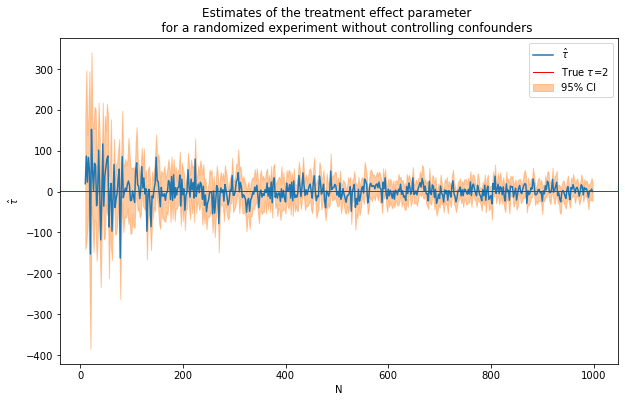

In [229]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without controlling confounders"""
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

## Directed Acyclic Graph: Not Controlling Covariates

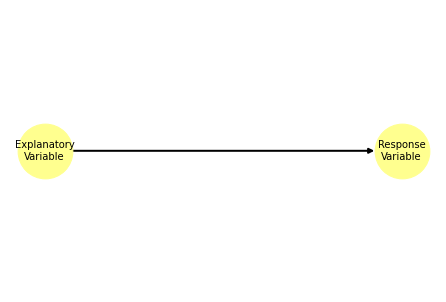

In [230]:
triangle_graph = nx.from_edgelist([('Explanatory\nVariable', 'Response\nVariable')], create_using=nx.DiGraph)
nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,
)

### Monte Carlo Simulations

In [235]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias=False,conf=False,flagX=False)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

 92%|███████████████████████████████████   | 1844/2000 [00:05<00:00, 336.67it/s]


KeyboardInterrupt: 

In [232]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.4580407456760554, RMSE=37.53618216990255, size=0.057
N=1000: bias=0.3022183323649837, RMSE=11.29126468312585, size=0.041


## b. Controlling for Covariates

### Simulating DGP

Model: $y_i = \tau*T_i+\beta'*x_i+e_i$

In [233]:
tau = 2
corr = .5
flagX=True # controlling for covariates
conf=False
selectBias=False
bias_mult = 0
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,bias_mult,Nrange,p,p0,corr,selectBias,conf,flagX)
print('Avg Tau-Hat:',sum(tauhats2)/len(tauhats2))
print('Avg SE-Hat:', sum(sehats2)/len(sehats2))


data = pd.DataFrame(dict(nvalues2=nvalues2,
                         tauhats2=tauhats2,
                         sehats2=sehats2,
                        lb2=lb2,ub2=ub2))

data.to_csv("withcovariates.csv", index=False)

100%|████████████████████████████████████████| 450/450 [00:04<00:00, 101.24it/s]

Avg Tau-Hat: 1.9949333420536912
Avg SE-Hat: 0.07451088325446929


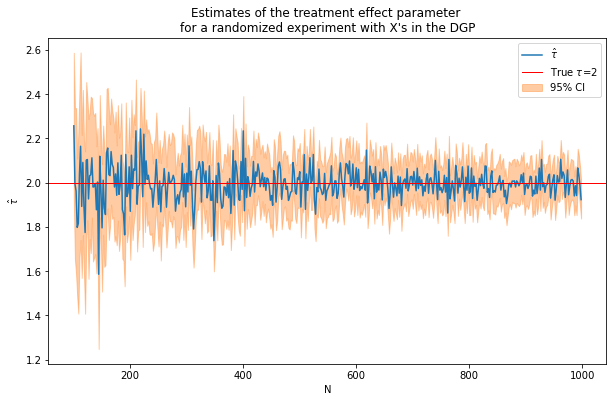

In [234]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

### Directed Acyclic Graph: Controlling Covariates

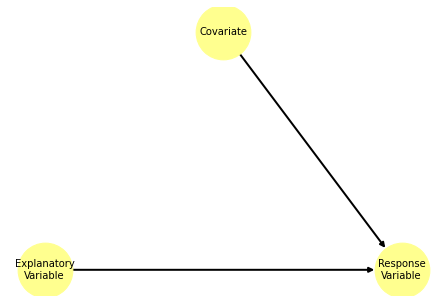

In [236]:
triangle_graph = nx.from_edgelist([('Explanatory\nVariable', 'Response\nVariable'),
                                   ('Covariate', 'Response\nVariable')], create_using=nx.DiGraph)
nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,
)

### Monte Carlo Simulation

In [237]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX=True)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhats = tauhats + [res.params[0]]
        sehats = sehats + [res.HC1_se[0]]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 60.18it/s]


In [238]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0002268893073757856, RMSE=0.20610702041503584, size=0.0735
N=1000: bias=6.496179099248755e-05, RMSE=0.04572791087155606, size=0.0465


### Real World Example

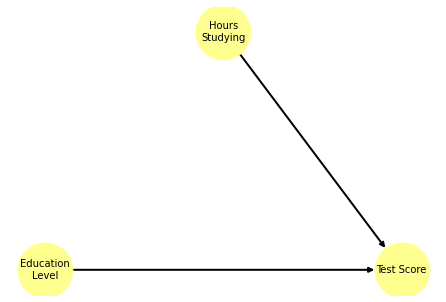

In [239]:
triangle_graph = nx.from_edgelist([('Education\nLevel','Test Score'),
                                  ('Hours\nStudying','Test Score')], create_using=nx.DiGraph)

nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,)

# 2. DGP with a Confounder

## a. Fail to control for confounder

### Simulating DGP

In [240]:
tau = 2
corr = .5
flagX = True
conf=False # confounder is not controlled for
selectBias = False
bias_mult = 0
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
(nvalues3,tauhats3,sehats3,lb3,ub3) = fn_run_experiments(tau,bias_mult,Nrange,p,p0,corr,selectBias,conf,flagX)
print('Avg Tau-Hat:', sum(tauhats3)/len(tauhats3))
print('Avg SE-Hat:', sum(sehats3)/len(sehats3))


data = pd.DataFrame(dict(nvalues3=nvalues3,
                         tauhats3=tauhats3,
                         sehats3=sehats3,
                        lb3=lb3,ub3=ub3))

data.to_csv("confounder_uncontrolled.csv", index=False)

100%|████████████████████████████████████████| 450/450 [00:04<00:00, 103.01it/s]


Avg Tau-Hat: 2.004448505897559
Avg SE-Hat: 0.07430791188337443


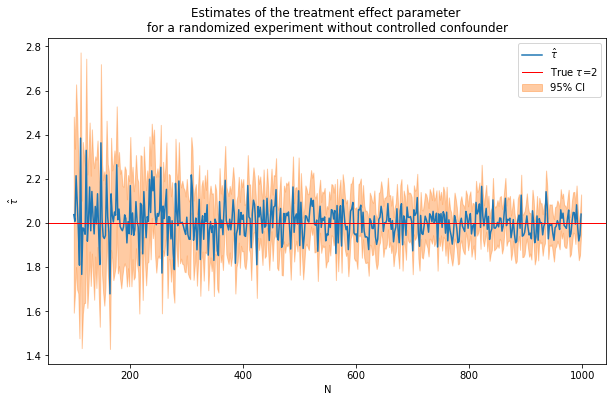

In [241]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment without controlled confounder"""
fn_plot_with_ci(nvalues3,tauhats3,tau,lb3,ub3,caption)

### Directed Acyclic Graph: Not Controlling for Confounder

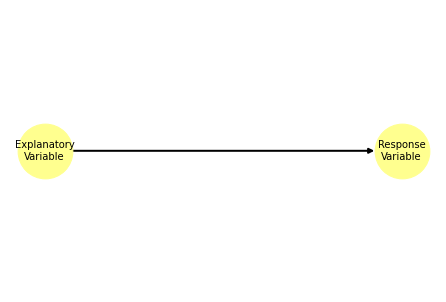

In [242]:
triangle_graph = nx.from_edgelist([('Explanatory\nVariable', 'Response\nVariable'), 
                                   ], create_using=nx.DiGraph)
nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,
)

### Monte Carlo Simulation

In [243]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhats = tauhats + [res.params[0]]
        sehats = sehats + [res.HC1_se[0]]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 60.16it/s]


In [244]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0028898918456535484, RMSE=0.20595245488613984, size=0.068
N=1000: bias=-0.0018571057998376362, RMSE=0.045428356003855246, size=0.053


## b. Controlling for Confounder

### Simulating DGP

In [245]:
tau = 2
corr = .5
conf=True # confounder is controlled for
bias_mult = 0
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
flagX = True
selectBias = False
(nvalues4,tauhats4,sehats4,lb4,ub4) = fn_run_experiments(tau,bias_mult,Nrange,p,p0,corr,selectBias,conf,flagX)
print('Avg Tau-Hat:', sum(tauhats4)/len(tauhats4))
print('Avg SE-Hat:', sum(sehats4)/len(sehats4))

data = pd.DataFrame(dict(nvalues4=nvalues4,
                         tauhats4=tauhats4,
                         sehats4=sehats4,
                        lb4=lb4,ub4=ub4))

data.to_csv("confounder_controlled.csv", index=False)

100%|█████████████████████████████████████████| 450/450 [00:04<00:00, 99.53it/s]


Avg Tau-Hat: 2.0083563529945265
Avg SE-Hat: 0.08571087000759296


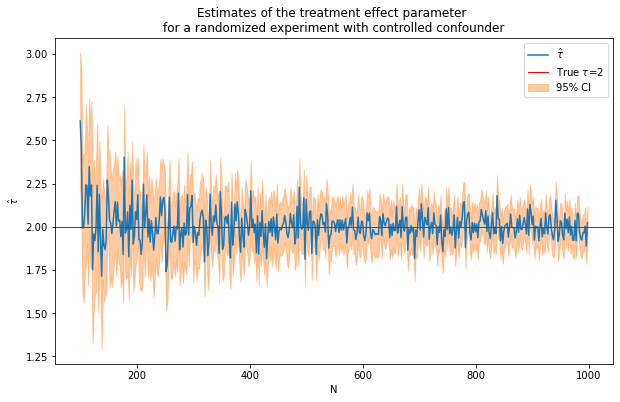

In [246]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with controlled confounder"""
fn_plot_with_ci(nvalues4,tauhats4,tau,lb4,ub4,caption)

### Directed Acyclic Graph: Controlling Confounder

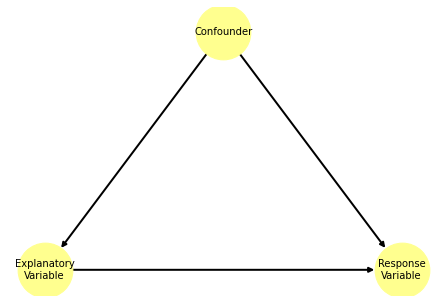

In [247]:
triangle_graph = nx.from_edgelist([('Explanatory\nVariable', 'Response\nVariable'), 
                                   ('Confounder', 'Response\nVariable'),
                                  ('Confounder', 'Explanatory\nVariable')], create_using=nx.DiGraph)
nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,
)

### Monte Carlo Simulation

In [248]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhats = tauhats + [res.params[0]]
        sehats = sehats + [res.HC1_se[0]]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 58.08it/s]


In [249]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.003716931142008633, RMSE=0.21764310908107518, size=0.0595
N=1000: bias=0.0025865854089474126, RMSE=0.05021260419184996, size=0.055


### Real World Example

A real world example of this would be smoking as a confounder, particularly related to the relationship between alcohol consumption and lung cancer. As smoking influences both lung cancer (dependent variable) and alcohol consumption (independent variable), it is likely to confound the data and results. See DAG below:

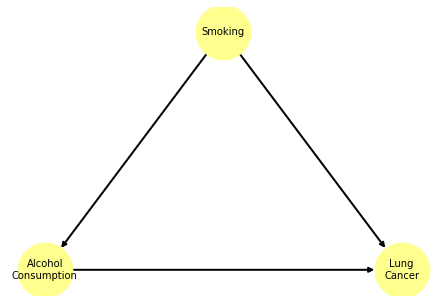

In [250]:
triangle_graph = nx.from_edgelist([('Alcohol\nConsumption', 'Lung\nCancer'), 
                                   ('Smoking', 'Lung\nCancer'),
                                  ('Smoking', 'Alcohol\nConsumption')], create_using=nx.DiGraph)
nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,
)

# 3. DGP with Selection Bias

## a. Controlling for Variable Between Path from Cause to Effect

### Simulating DGP

In [274]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
bias_mult = 10
Nrange = range(100,1000,2) # loop over N values
flagX = True
selectBias = True # controlling for bias
(nvalues5,tauhats5,sehats5,lb5,ub5) = fn_run_experiments(tau,bias_mult,Nrange,p,p0,corr,selectBias,conf,flagX)
print('Avg Tau-Hat:', sum(tauhats5)/len(tauhats5))
print('Avg SE-Hat:', sum(sehats5)/len(sehats5))

data = pd.DataFrame(dict(nvalues5=nvalues5,
                         tauhats5=tauhats5,
                         sehats5=sehats5,
                        lb5=lb5,ub5=ub5))

data.to_csv("bias_controlled.csv", index=False)

100%|████████████████████████████████████████| 450/450 [00:04<00:00, 104.54it/s]

Avg Tau-Hat: 7.0018836312013635
Avg SE-Hat: 0.4067824040942974


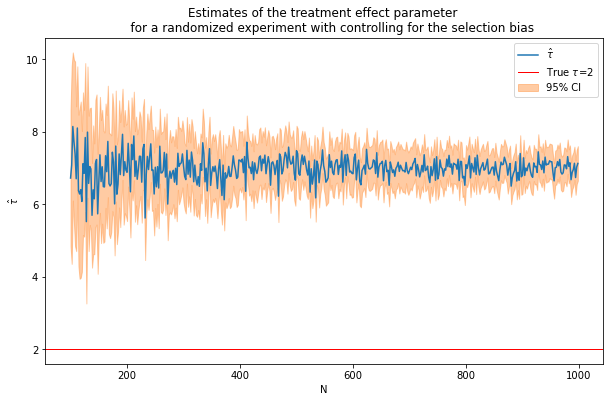

In [267]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment with controlling for the selection bias"""
fn_plot_with_ci(nvalues5,tauhats5,tau,lb5,ub5,caption)

### Directed Acyclical Graph: Controlling for Bias

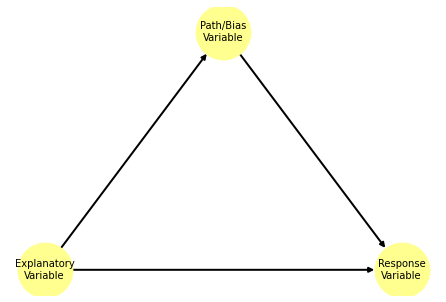

In [255]:
triangle_graph = nx.from_edgelist([('Explanatory\nVariable', 'Response\nVariable'), 
                                   ('Path/Bias\nVariable', 'Response\nVariable'),
                                  ('Explanatory\nVariable', 'Path/Bias\nVariable')], create_using=nx.DiGraph)
nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,
              )

### Monte Carlo Simulation

In [275]:
Ylist = []
Tlist = []
Slist = []
Xlist = []

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        # control for covariates and mediator variable
        Yexp,T,X,S = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX)
        Ylist.append(Yexp)
        Tlist.append(T)
        Slist.append(S)
        Xlist.append(X)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs,S],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        sehat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [sehat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 58.41it/s]


In [276]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.00198590156500373, RMSE=0.23776088645291363, size=0.069
N=1000: bias=-0.0002529896199627031, RMSE=0.05224229035763532, size=0.047


## b. Do Not Control for the Variable Between Cause and Effect 

### Simulating DGP

In [269]:
tau = 2
corr = .5
conf=False
p = 100
p0 = 50 # number of covariates used in the DGP
bias_mult = 10
Nrange = range(100,1000,2) # loop over N values
flagX = True
selectBias = False # not controlling for bias
(nvalues6,tauhats6,sehats6,lb6,ub6) = fn_run_experiments(tau,bias_mult,Nrange,p,p0,corr,selectBias,conf,flagX)
print('Avg Tau-Hat:', sum(tauhats6)/len(tauhats6))
print('Avg SE-Hat:', sum(sehats6)/len(sehats6))

data = pd.DataFrame(dict(nvalues6=nvalues6,
                         tauhats6=tauhats6,
                         sehats6=sehats6,
                        lb6=lb6,ub6=ub6))

data.to_csv("bias_uncontrolled.csv", index=False)

100%|█████████████████████████████████████████| 450/450 [00:04<00:00, 99.18it/s]

Avg Tau-Hat: 7.00885430733535
Avg SE-Hat: 0.4030617809434762


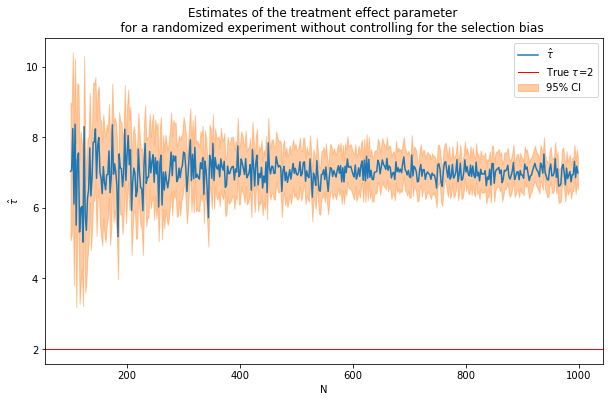

In [270]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment without controlling for the selection bias"""
fn_plot_with_ci(nvalues6,tauhats6,tau,lb6,ub6,caption)

### Directed Acyclical Graph: Not Controlling for Graph

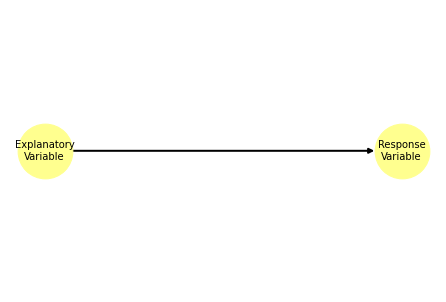

In [260]:
triangle_graph = nx.from_edgelist([('Explanatory\nVariable', 'Response\nVariable')], create_using=nx.DiGraph)
nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,
              )

### Monte Carlo Simulations

In [271]:
Ylist = []
Tlist = []
Xlist = []

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        # control for both covariates and mediator variable
        Yexp,T,X = fn_generate_data(tau,bias_mult,N,p,p0,corr,selectBias,conf,flagX)
        Ylist.append(Yexp)
        Tlist.append(T)
        Xlist.append(X)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        sehat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [sehat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|███████████████████████████████████████| 2000/2000 [00:34<00:00, 58.26it/s]


In [272]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=5.013516460322466, RMSE=5.123334812778356, size=0.988
N=1000: bias=4.998907436489607, RMSE=5.002089058026708, size=1.0


### Real World Example

A real world example of selection bias and path variables often involves use of the internet. For example, when job training programs are offered, as an effort to improve employment, they are largely offered through the internet. As such, selection of the program is heavily biased by participants' access to internet connection (or whether they have internet in their homes). See DAG below:

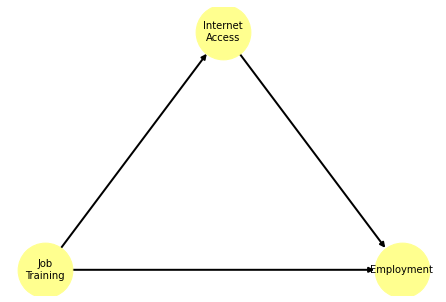

In [105]:
triangle_graph = nx.from_edgelist([('Job\nTraining', 'Employment'), 
                                   ('Internet\nAccess', 'Employment'),
                                  ('Job\nTraining', 'Internet\nAccess')], create_using=nx.DiGraph)
nx.draw_planar(triangle_graph,
    with_labels=True,
    node_size=3000,
    node_color="#ffff8f",
    width=2,
    font_size=10,
              )